In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [0]:
confirmed_df.head(20)

In [0]:
confirmed_df[confirmed_df['Country/Region']=='India'] 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
131,NaN,India,21.0,78.0,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,62,73,82,102,113,119,142,156,194,244,330,396,499,536,657,727,887,987,1024,1251,1397,1998,2543,2567,3082,3588,4778,5311,5916,6725,7598,8446,9205,10453,11487,12322,13430,14352,15722,17615


In [0]:
deaths_df[deaths_df['Country/Region']=='India']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
131,NaN,India,21.0,78.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,2,2,2,3,3,4,5,4,7,10,10,12,20,20,24,27,32,35,58,72,72,86,99,136,150,178,226,246,288,331,358,393,405,448,486,521,559


In [0]:
confirmed_df[confirmed_df['Country/Region']=='US']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
225,NaN,US,37.0902,-95.7129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36,40,47,54,63,85,108,118,200,244,307,417,557,706,942,1209,1581,2026,2467,2978,3873,4757,5926,7087,8407,9619,10783,12794,14695,16544,18586,20462,22019,23528,25831,28325,32916,36773,38664,40661


In [0]:
deaths_df[deaths_df['Country/Region']=='US']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
225,NaN,US,37.0902,-95.7129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36,40,47,54,63,85,108,118,200,244,307,417,557,706,942,1209,1581,2026,2467,2978,3873,4757,5926,7087,8407,9619,10783,12794,14695,16544,18586,20462,22019,23528,25831,28325,32916,36773,38664,40661


In [0]:
cols = confirmed_df.keys()

Get all the dates for the outbreak

In [0]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24


In [0]:
confirmed_india = confirmed_df.loc[confirmed_df['Country/Region']=='India', cols[4]:cols[-1]]
deaths_india = deaths_df.loc[deaths_df['Country/Region']=='India', cols[4]:cols[-1]]
recoveries_india = recoveries_df.loc[recoveries_df['Country/Region']=='India', cols[4]:cols[-1]]

In [0]:
recoveries_india

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,4,4,4,4,13,13,14,14,15,20,23,27,27,40,43,45,73,84,95,102,123,148,191,192,229,229,375,421,506,620,774,969,1080,1181,1359,1432,1768,2041,2463,2854


In [0]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)

In [0]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [0]:
days_since_1_22

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],

Future forcasting

In [0]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [0]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.15, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [0]:
# use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [0]:
# svm_search.best_params_

In [0]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 112422.05216249185
MSE: 22659988205.600574


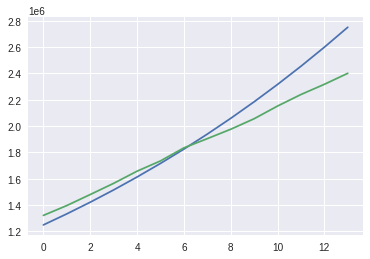

In [0]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [0]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 1282052.2906708817
MSE: 1738110052141.5945


In [0]:
print(linear_model.coef_)
print(linear_model.intercept_)

[[7091.54069291]]
0.0


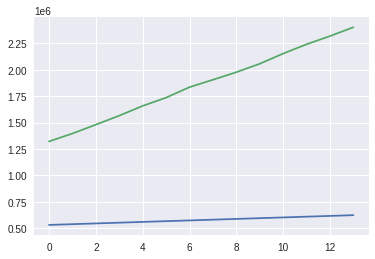

In [0]:
plt.plot(test_linear_pred)
plt.plot(y_test_confirmed)

In [0]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [0]:
bayesian_search.best_params_

{'alpha_1': 0.0001,
 'alpha_2': 1e-06,
 'lambda_1': 1e-05,
 'lambda_2': 1e-05,
 'tol': 0.01}

In [0]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 1165419.7059076715
MSE: 1443708324086.2468


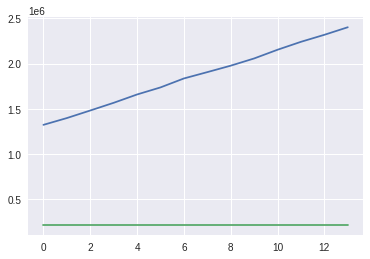

In [0]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)

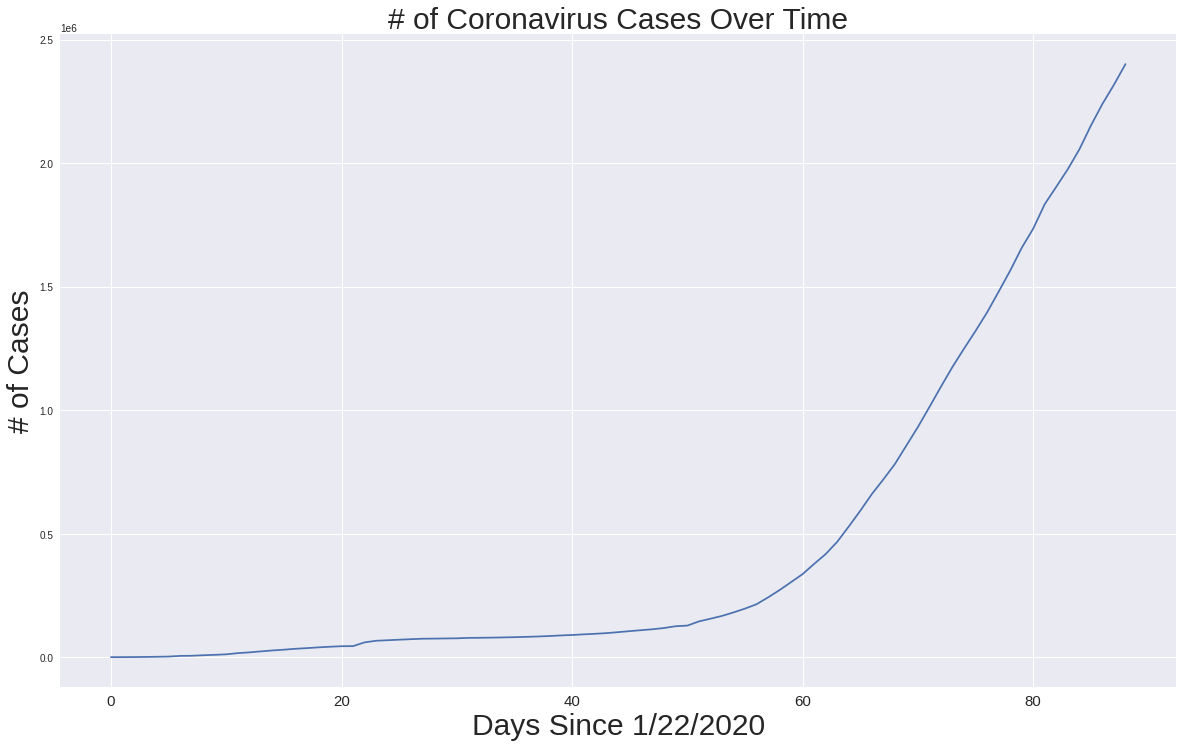

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=15)
plt.show()

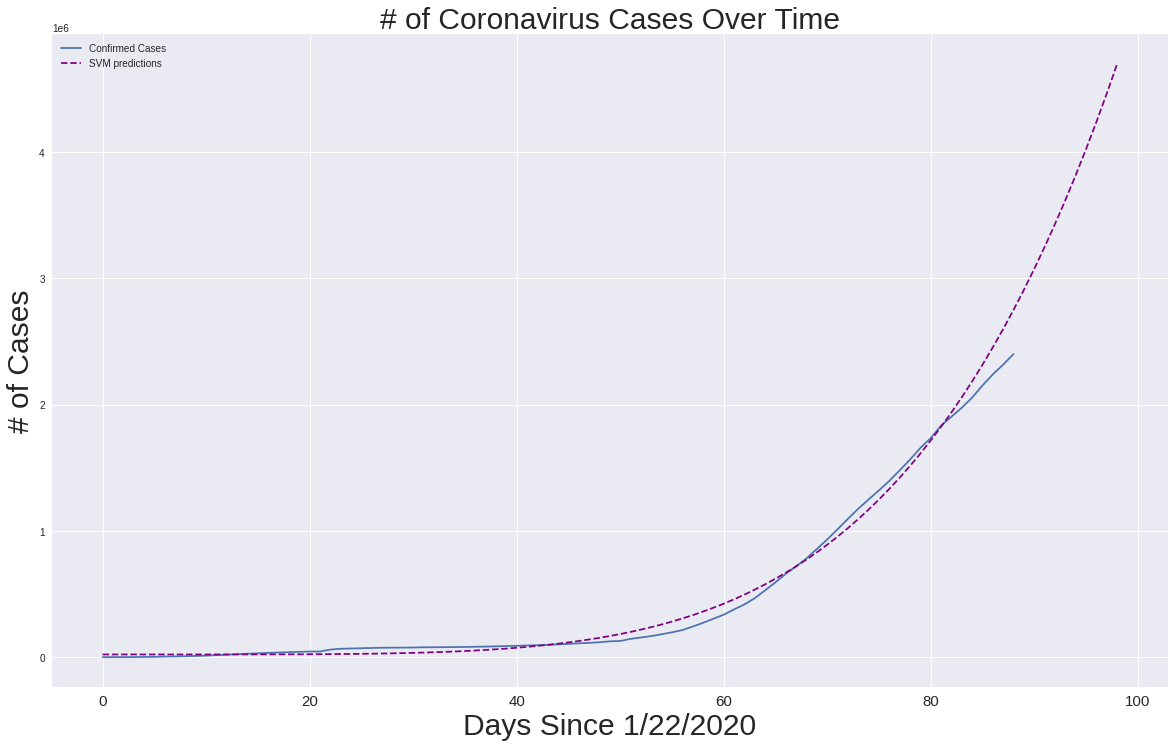

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'])
plt.xticks(size=15)
plt.show()

 Graphing the number of confirmed cases, deaths, active cases, and the mortality rate over time, as well as the number of recoveries

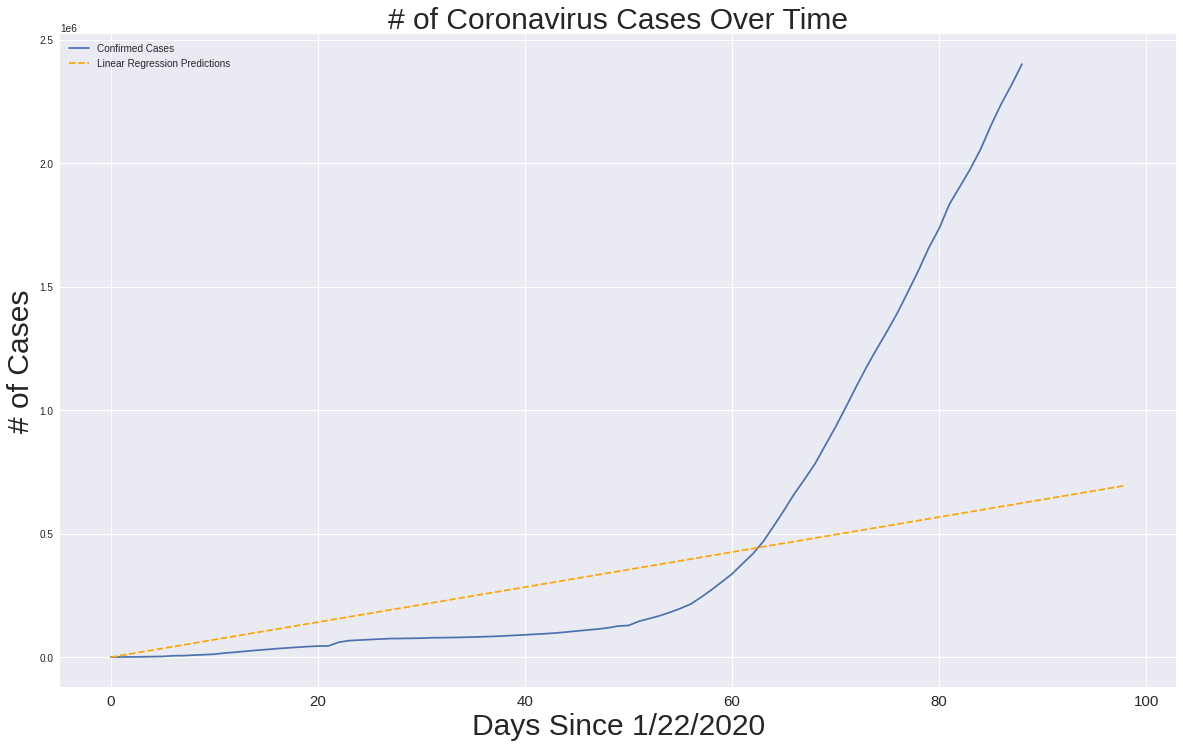

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Predictions'])
plt.xticks(size=15)
plt.show()

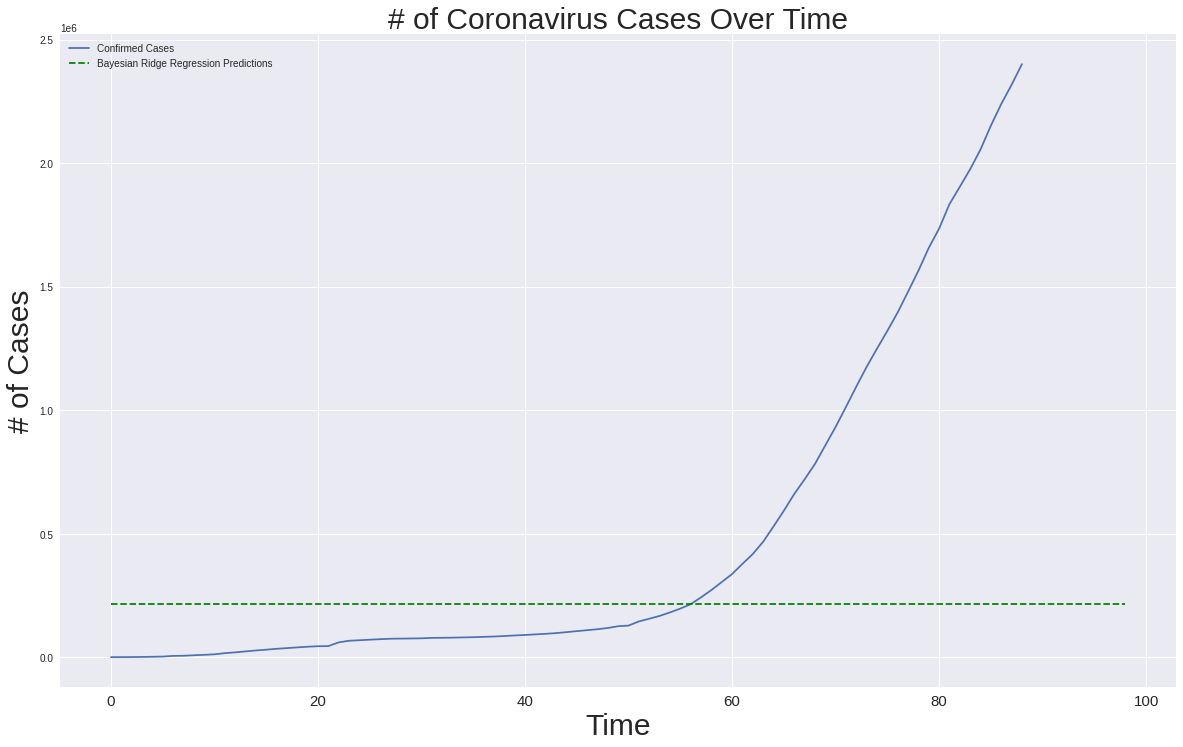

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Bayesian Ridge Regression Predictions'])
plt.xticks(size=15)
plt.show()

In [0]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('04/20/2020', 2909942.0),
 ('04/21/2020', 3075881.0),
 ('04/22/2020', 3249362.0),
 ('04/23/2020', 3430638.0),
 ('04/24/2020', 3619969.0),
 ('04/25/2020', 3817622.0),
 ('04/26/2020', 4023866.0),
 ('04/27/2020', 4238979.0),
 ('04/28/2020', 4463245.0),
 ('04/29/2020', 4696952.0)}

In [0]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('04/20/2020', 214302.0),
 ('04/21/2020', 214302.0),
 ('04/22/2020', 214302.0),
 ('04/23/2020', 214302.0),
 ('04/24/2020', 214302.0),
 ('04/25/2020', 214302.0),
 ('04/26/2020', 214302.0),
 ('04/27/2020', 214302.0),
 ('04/28/2020', 214302.0),
 ('04/29/2020', 214302.0)}

In [0]:
# Future predictions using Linear Regression 
print('Linear regression future predictions:')
print(np.round(linear_pred[-10:]))

Linear regression future predictions:
[[631147.]
 [638239.]
 [645330.]
 [652422.]
 [659513.]
 [666605.]
 [673696.]
 [680788.]
 [687879.]
 [694971.]]


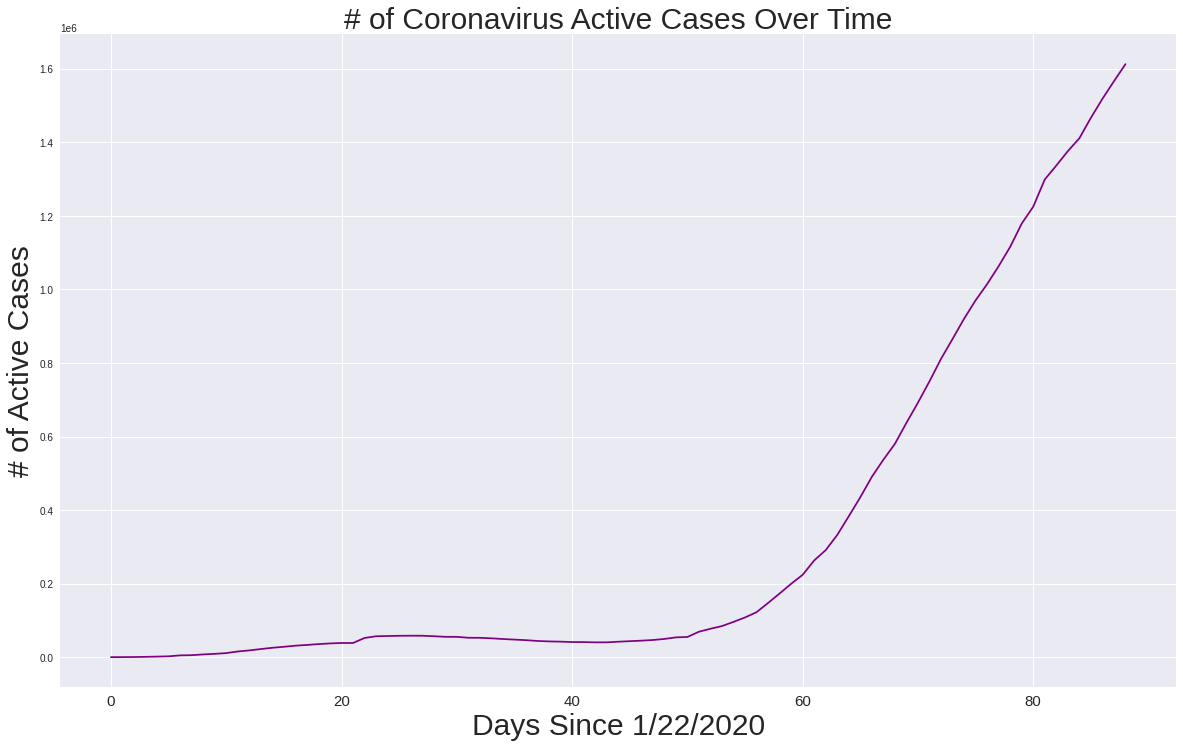

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_active, color='purple')
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=15)
plt.show()

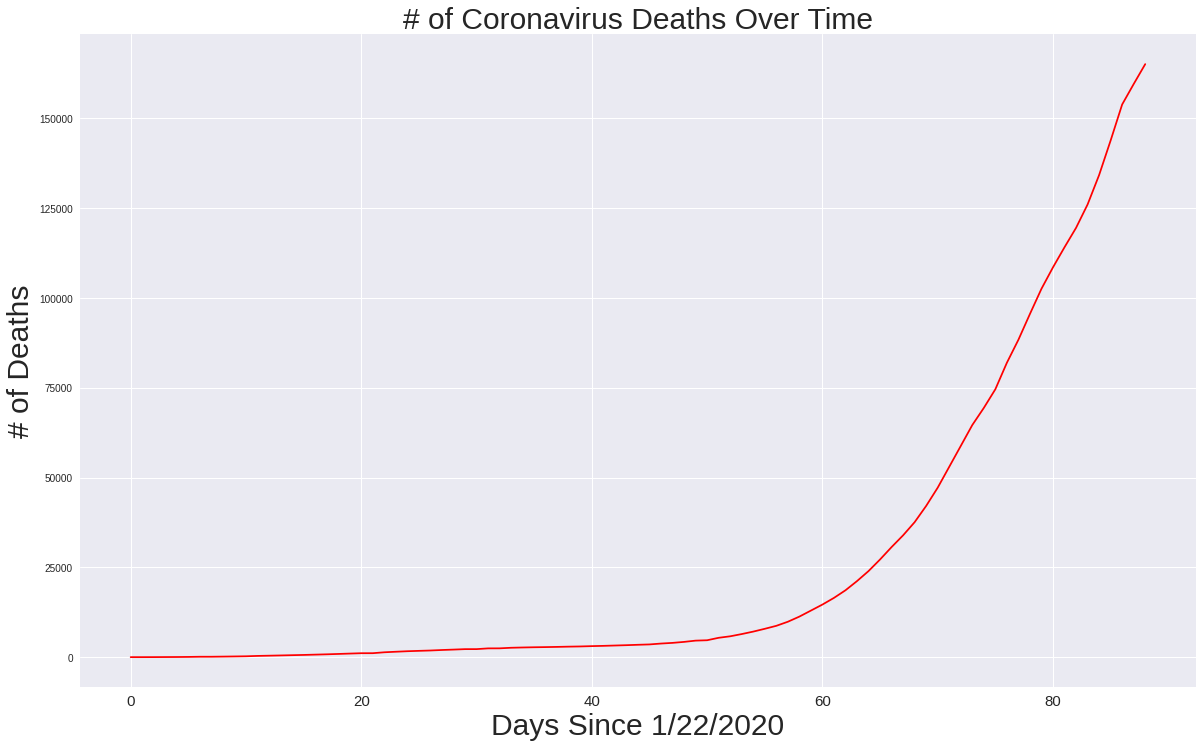

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=15)
plt.show()

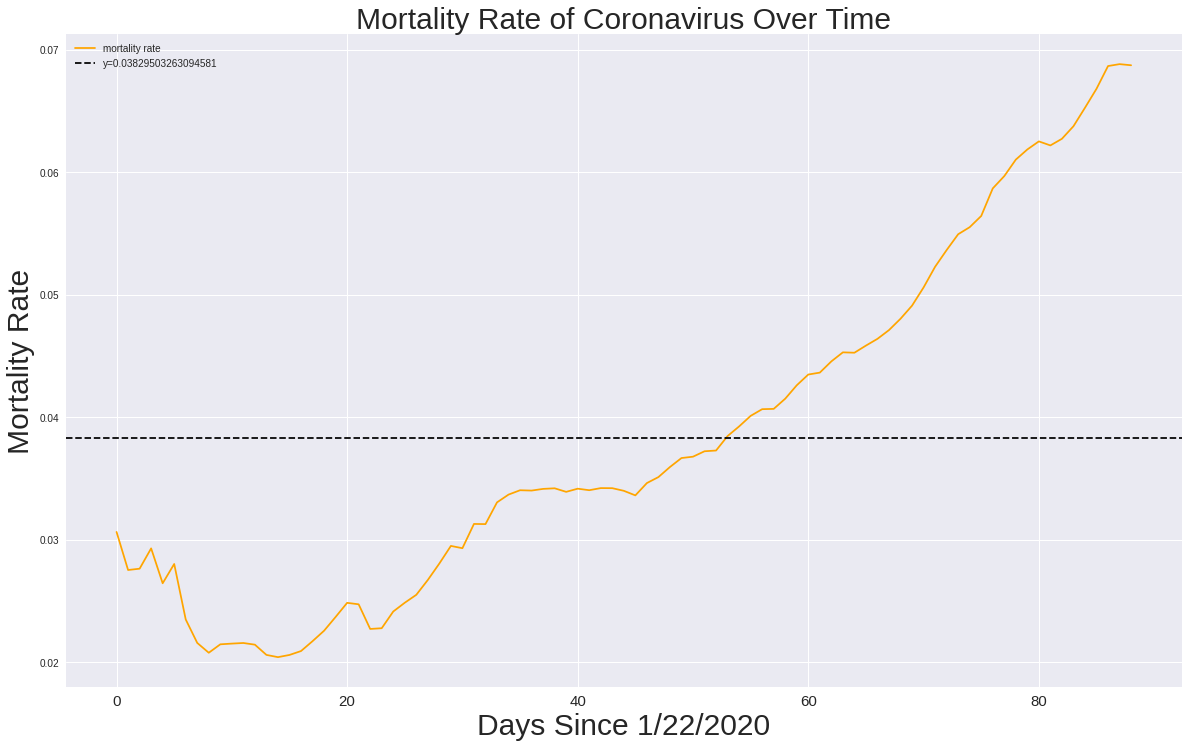

In [0]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)])
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=15)
plt.show()

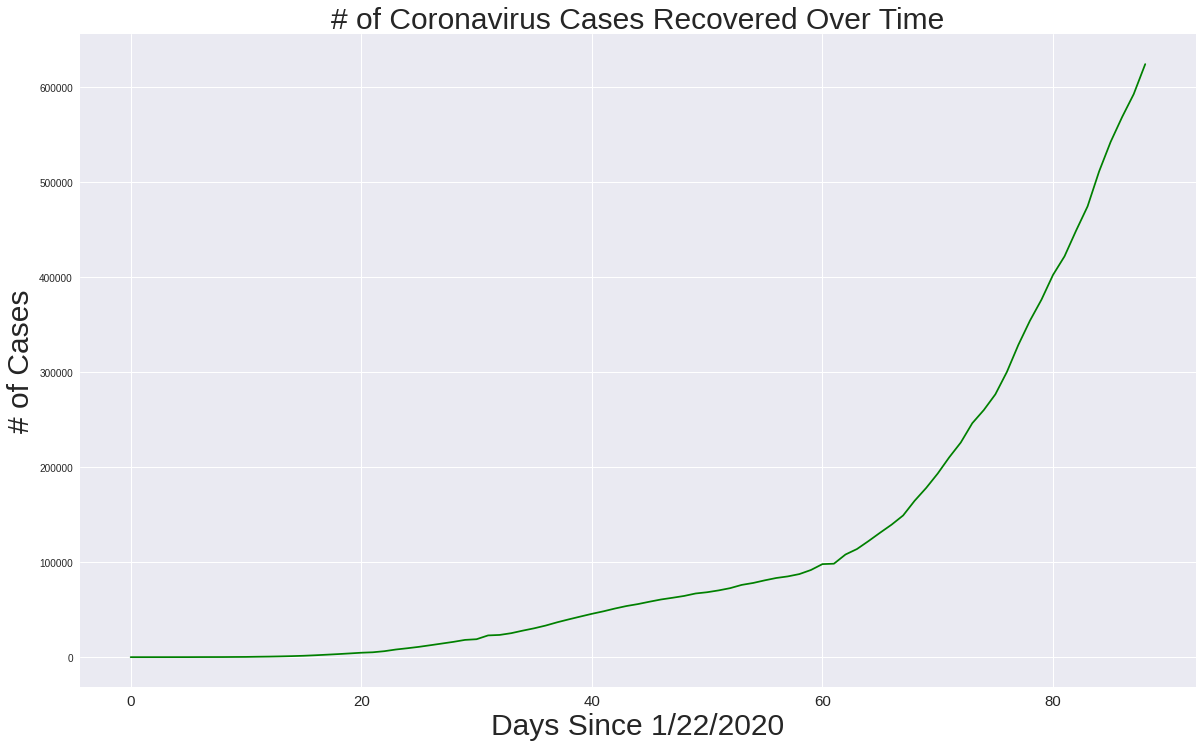

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=15)
plt.show()

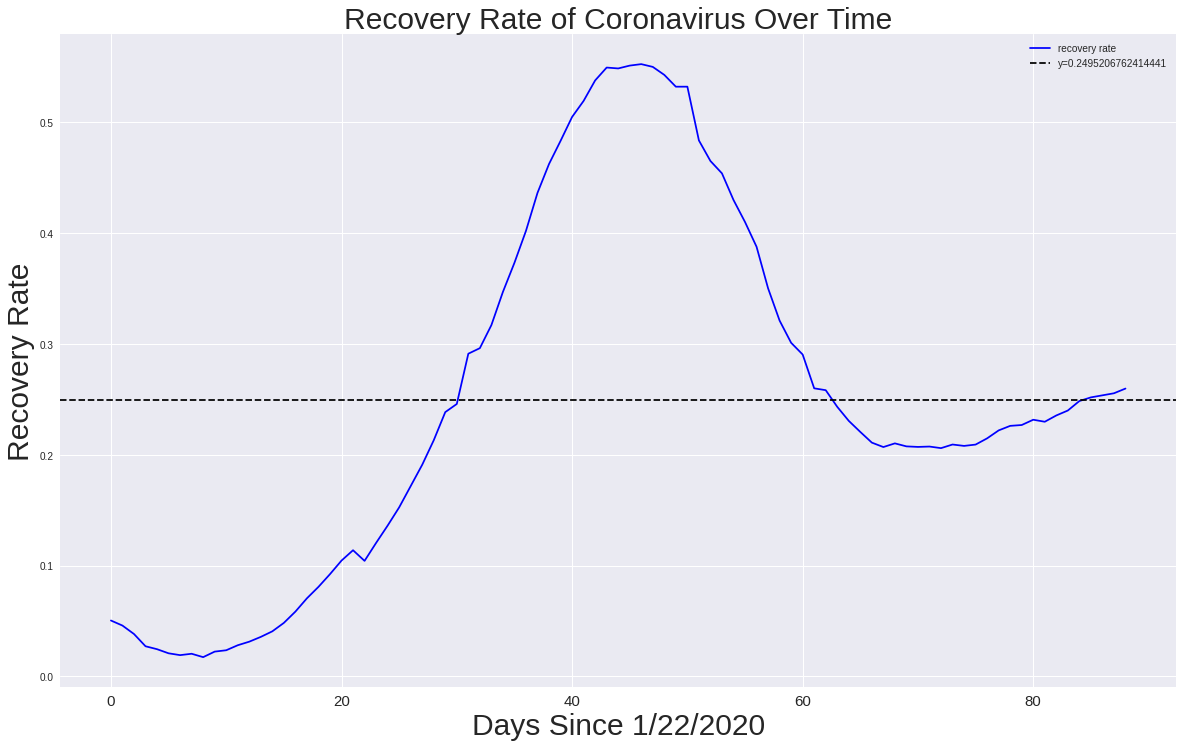

In [0]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)])
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=15)
plt.show()

Graphing deaths against recoveries

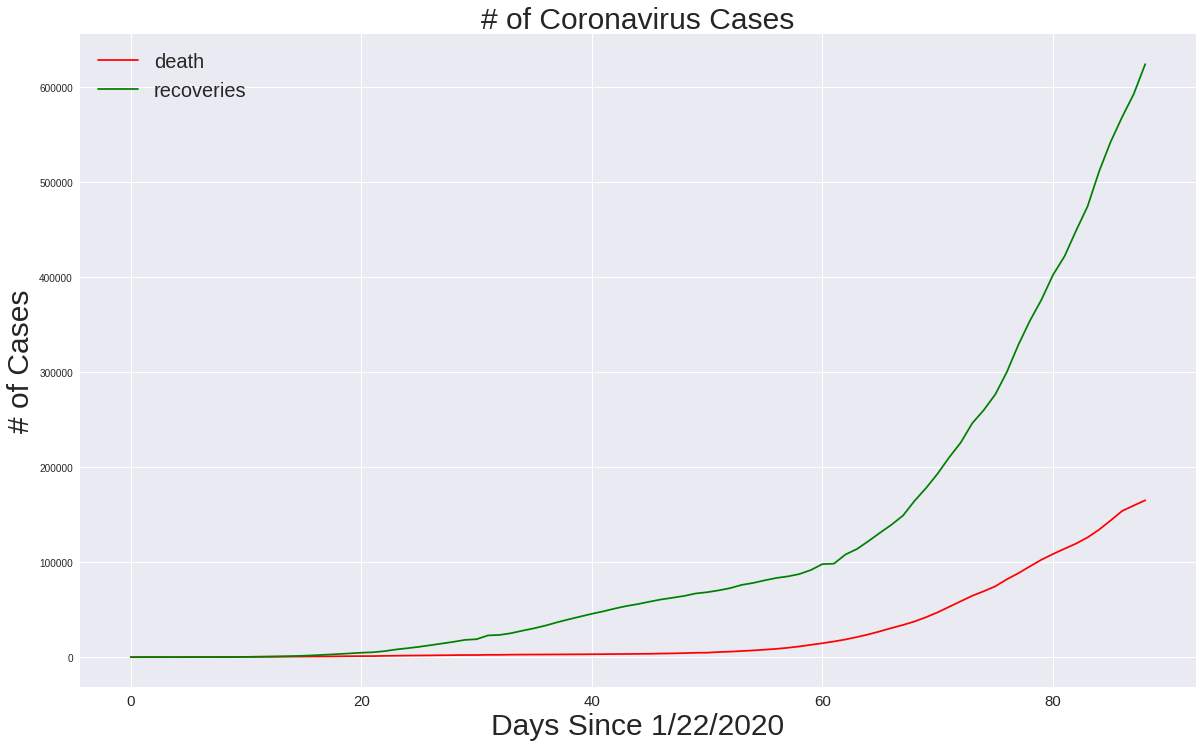

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=15)
plt.show()

Plotting the number of deaths against the number of recoveries

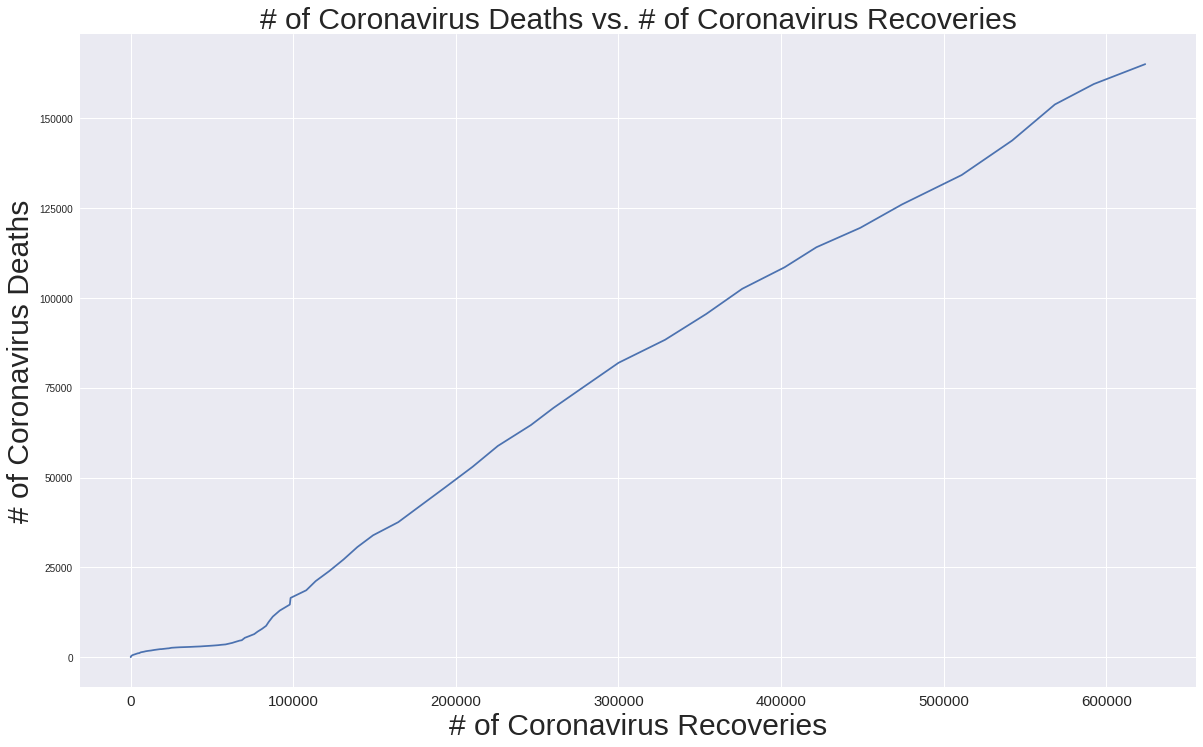

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=15)
plt.show()

In [0]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]

Getting information about countries/regions that have confirmed coronavirus cases

In [0]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [0]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region']==unique_countries[i]].sum()

In [0]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Countries/Regions:
US: 759086 cases
Spain: 198674 cases
Italy: 178972 cases
France: 154097 cases
Germany: 145184 cases
United Kingdom: 121172 cases
Turkey: 86306 cases
China: 83805 cases
Iran: 82211 cases
Russia: 42853 cases
Brazil: 38654 cases
Belgium: 38496 cases
Canada: 35632 cases
Netherlands: 32838 cases
Switzerland: 27740 cases
Portugal: 20206 cases
India: 17615 cases
Peru: 15628 cases
Ireland: 15251 cases
Austria: 14749 cases
Sweden: 14385 cases
Israel: 13491 cases
Japan: 10797 cases
Korea, South: 10661 cases
Chile: 10088 cases
Ecuador: 9468 cases
Saudi Arabia: 9362 cases
Poland: 9287 cases
Romania: 8746 cases
Pakistan: 8348 cases
Denmark: 7580 cases
Mexico: 7497 cases
Norway: 7078 cases
United Arab Emirates: 6781 cases
Czechia: 6746 cases
Singapore: 6588 cases
Indonesia: 6575 cases
Australia: 6547 cases
Serbia: 6318 cases
Philippines: 6259 cases
Ukraine: 5449 cases
Qatar: 5448 cases
Malaysia: 5389 cases
Belarus: 4779 cases
Dominican Republic: 4680 cases
Panam

In [0]:
unique_provinces =  list(confirmed_df['Province/State'].unique())
# those are countries, which are not provinces/states.
outliers = ['United Kingdom', 'Denmark', 'France']
# for i in outliers:
#     unique_provinces.remove(i)

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [0]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==unique_provinces[i]].sum()

In [0]:
# number of cases per province/state/city
print('Confirmed Cases by Province/States (US, China, Australia, Canada):')
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Confirmed Cases by Province/States (US, China, Australia, Canada):
Hubei: 68128 cases
Quebec: 17950 cases
Ontario: 11561 cases
New South Wales: 2926 cases
Alberta: 2803 cases
British Columbia: 1647 cases
Guangdong: 1580 cases
Victoria: 1319 cases
Henan: 1276 cases
Zhejiang: 1268 cases
Hong Kong: 1025 cases
Hunan: 1019 cases
Queensland: 1015 cases
Anhui: 991 cases
Jiangxi: 937 cases
Heilongjiang: 898 cases
Shandong: 787 cases
Nova Scotia: 675 cases
Jiangsu: 653 cases
Shanghai: 635 cases
Beijing: 593 cases
Chongqing: 579 cases
Sichuan: 561 cases
Western Australia: 541 cases
Channel Islands: 488 cases
South Australia: 435 cases
Reunion: 408 cases
Fujian: 355 cases
Hebei: 328 cases
Saskatchewan: 315 cases
Isle of Man: 298 cases
Mayotte: 271 cases
Newfoundland and Labrador: 257 cases
Shaanxi: 256 cases
Manitoba: 254 cases
Guangxi: 254 cases
Shanxi: 197 cases
Inner Mongolia: 193 cases
Tianjin: 189 cases
Faroe Islands: 185 cases
Yunnan: 184 cases
Tasmania: 180 cases
Hainan: 168 cases
Martiniq

In [0]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

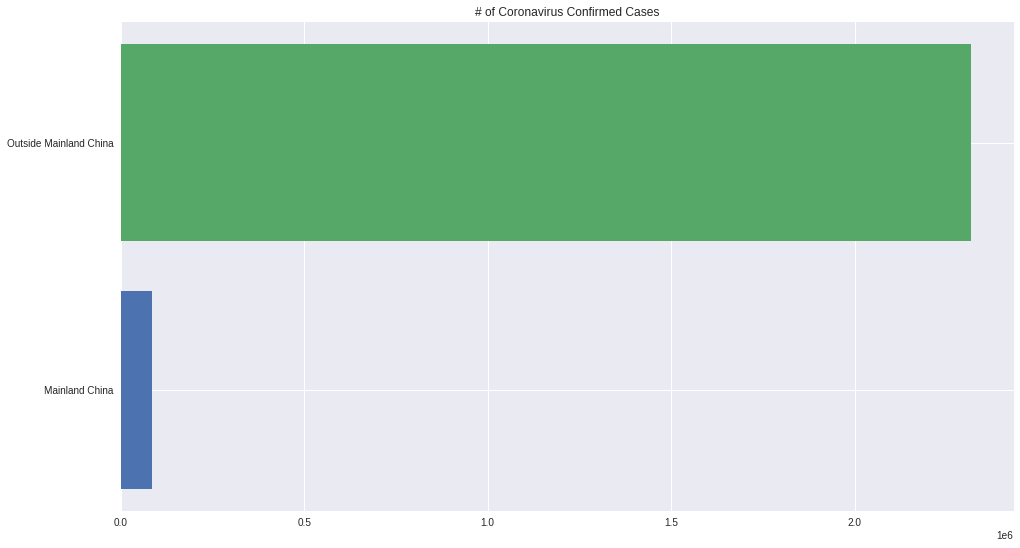

In [0]:
china_confirmed = latest_confirmed[confirmed_df['Country/Region']=='China'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases')
plt.show()

In [0]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

In [0]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

In [0]:
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.show()

In [0]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.show()

In [0]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

In [0]:
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_provinces, visual_confirmed_cases2)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.show()

In [0]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.show()

In [0]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per Country')
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best')
plt.show()

In [0]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per State/Province/Region')
plt.pie(visual_confirmed_cases2, colors=c)
plt.legend(visual_unique_provinces, loc='best')
plt.show()

In [0]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China')
plt.pie(visual_confirmed_cases[1:], colors=c)
plt.legend(visual_unique_countries[1:], loc='best')
plt.show()

In [0]:
us_regions = list(confirmed_df[confirmed_df['Country/Region']=='US']['Province/State'].unique())
us_confirmed_cases = []
no_cases = [] 
for i in us_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        us_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_regions.remove(i)

In [0]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the United States')
plt.pie(us_confirmed_cases, colors=c)
plt.legend(us_regions, loc='best')
plt.show()

In [0]:
china_regions = list(confirmed_df[confirmed_df['Country/Region']=='China']['Province/State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)

In [0]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the Mainland China')
plt.pie(china_confirmed_cases, colors=c)
plt.legend(china_regions, loc='best')
plt.show()